<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W2D3_DecisionMaking/student/W2D3_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 1 Part 2 - Hidden Markov Model

Please execute the cell below to initialize the notebook environment

In [1]:
!pip install hmmlearn pandas

import numpy as np                 # import numpy
import scipy.stats as ss
import pandas as pd
from hmmlearn import hmm

import matplotlib.pyplot as plt    # import matplotlib
from IPython import display
from matplotlib import patches

In [2]:
#@title Figure Settings
fig_w, fig_h = (12,8)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
plt.style.use('ggplot')

%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

Video available at https://youtu.be/ZNPUqDI7BqY


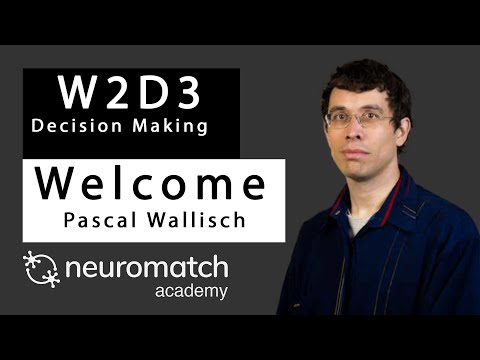

In [3]:
#@title Intro Video
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="ZNPUqDI7BqY", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

---

## Tutorial objectives

In this notebook we'll first simulate a Hidden Markov Model and observe how uncertainty increases as we make future predictions without evidence and how to gain information from evidence.
The HMM model we use in this tutorial will have binary latent variable $x_t \in \{0,1\}$ and 1D Gaussian emmision model $y_t|x_t \sim \mathcal{N}(\mu_{x_t},\sigma^2_{x_t})$

After that, you will implement a HMM of a network of spiking neurons mentioned in today's intro and:

* Implement the forward-backward algorithm
* Complete the E-step and M-step 
* Learning parameters for the example problem using EM algorithm

## Binary HMM with Gaussian observations

Video available at https://youtu.be/VmarfRhrMmk


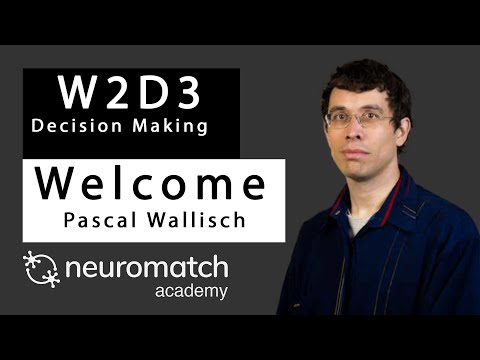

In [4]:
#@title Exercise 1 Video
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="VmarfRhrMmk", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

---

### EXERCISE 1:  Prediction without evidence 

<img src="https://drive.google.com/uc?export=view&id=1KacYR3RQZqtq-tudkQpyKZER9LeYPqiw" alt="drawing" width="400"/>

In contrast with Sequential Probability Ratio Test, in HMM $p(x_t)$ is dependent on  $p(x_{t-1})$, thus we could make predictions of future latent states even without further evidence, which makes it a pure Markov chain. In this case the influence of $x_0$ will decay exponentially with time.

In a pure Markov Chain, our predictive marginal distribution of $x_t$ given predictive marginal distribution of $x_{t-1}$ can be calculated recursively by

$$ p(x_t=i) = \sum_j A_{ji} p(x_{t-1}=j) \tag{1}$$

where $A$ is the transition matrix and $A_{ij}$ represents the transition probability to switch from state $i$ to state $j$ at next time step.

The entropy of a discrete distribution $p(x)$ is:

$$ H(p(x)) =- \sum_x p(x)\log_2 p(x) $$ and the unit is **bit** since we use base-2 logarithm here.

In this exercise, we've already coded up an non-stochastic HMM for you using the package `hmmlearn`. You will observe the behavior of this deterministic HMM, modify the code to a stochastic HMM with Gaussian observations, and then calculate and visualize how we lose information in pure predictions.

---
Please familarize yourself with the code and complete the following exercises in the next two cells:

**Suggestions**

1. (Cell 1) Generate a sequence of latent states and measurements. Use our provided code to visualize them.
2. (Cell 2) Complete the function `my_create_model` by copying and adapting the code from `create_model` to create an HMM model with stochastic transition matrix. In this model, $x$ will have 90% probability to stay at it's old state.
3. (Cell 2) Complete the function `my_create_model` by further changing the emission models to Gaussian distributions with mean $-1$ and $+1$ respectively and standard deviation $\sigma=1$ for both.
4. (Cell 2) For the modified model, generate a sequence of latent states and measurements. Use our provided code to visualize them.




In [5]:
#@title Plotting functions
def plot_hmm1(model, states, observations):
  """Plots HMM states and observations for 1d states and observations.

  Args:
    model (hmmlearn model):               hmmlearn model used to get state means.
    states (numpy array of floats):       Samples of the states.
    observations (numpy array of floats): Samples of the states.
  """

  nsteps = states.size
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
  ax = axes[0]
  states_forplot = list(map(lambda s:model.means_[s], states))
  ax.step(np.arange(nstep), states_forplot,"--", where="mid", alpha=0.5,c="orange")
  ax.set_xlabel("Time")
  ax.set_ylabel("State (in observation mean)")
  ax.set_ylim([-2.0, 2.0])

  ax = axes[1]
  ax.step(np.arange(nstep), observations, c="blue",where="mid")
  ax.set_xlabel("Time")
  ax.set_ylabel("Observation")
  ax.set_ylim([-2.0, 2.0])
  plt.show(fig)

In [6]:
def create_model():
    """
    Create an HMM with binary state variable and 1D Gaussian observations
    The probability to switch to the other state is 1. Two observation models have 
    mean 1.0 and -1.0 respectively and almost zero standard deviation

    Returns:
        model (hmm.GaussianHMM instance): the described HMM
    """
    n_components = 2
    model = hmm.GaussianHMM(n_components=n_components, covariance_type="full")
    model.startprob_ = np.array([1.0, 0.0])
    model.transmat_ = np.array([[0.0, 1.0],[1.0, 0.0]])
    model.means_ = np.array([[1.0],[-1.0]])
    model.covars_ = np.tile(np.eye(1) * 1e-8 , (2, 1, 1))
    model.sample(1)
    return model


nstep = 15
model = create_model()
###############################################################################
## Insert your code here to:
##      Replace the next 3 lines and generate a sequence of observations and latent states and assign them to 
##      variables `observations` and `states`
##      Hint: use `model.sample`
###############################################################################
# observations, states = ...

###############################################################################
## After finishing the above exercises, please un-comment the following lines
###############################################################################

# observations = observations.flatten()
# table = pd.DataFrame({"states": states,"observations":observations})
# print(table)

# plot_hmm1(model, states, observations)


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D3_DecisionMaking/solutions/W2D3_Tutorial2_Solution_561c2507.py)

*Example output:*

<img alt='Solution hint' align='left' width=968 height=395 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D3_DecisionMaking/static/W2D3_Tutorial2_Solution_561c2507_1.png>



In [8]:
def my_create_model(switch_prob=0.1,noise_level=0.5):
    """
    Create an HMM with binary state variable and 1D Gaussian observations
    The probability to switch to the other state is `switch_prob`. Two observation models have 
    mean 1.0 and -1.0 respectively. `noise_level` specifies the standard deviation of the observation
    models.

    Args:
        switch_prob (float): probability to jump to the other state
        noise_level (float): standard deviation of observation models. Same for two components
    Returns:
        model (hmm.GaussianHMM instance): the described HMM
    """
    ###############################################################################
    ## Insert your code here to:
    ##      * Change the transition matrix so there's 90% chance to stay in old state
    ##		* Change the observation model variances to `noise_level`^2
    ##      Hint: you could copy the code from function `create_model` in Cell 1 and change the numbers
    ###############################################################################
    raise NotImplementedError("function `my_create_model` incomplete")

nstep = 100

###############################################################################
## After finishing the above exercises, please un-comment the following lines
###############################################################################
# model = my_create_model()
# observations, states = model.sample(nstep)
# observations = observations.reshape(-1)

# table = pd.DataFrame({"states": states,"observations":observations})
# print(table)

# plot_hmm1(model, states, observations)


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D3_DecisionMaking/solutions/W2D3_Tutorial2_Solution_e03023c9.py)

*Example output:*

<img alt='Solution hint' align='left' width=968 height=395 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D3_DecisionMaking/static/W2D3_Tutorial2_Solution_e03023c9_1.png>



---

Using the model you just defined, let's now make some predictions about $x_t$ given that we know $x_0=1$ for sure. We've already imposed this assumption by setting prior probabilities of $p(x_0)$ to $[1,0]$ earlier. 

**Suggestions** 


1. (Cell 3) Complete the code in function `markov_forward` to calculate the predictive marginal distribution at next time step using `p_next = A.T @ p_current` 
2. (Cell 3) Complete the function `entropy_categorical` to calculate the entropy for a Catergorical distribution (in which Bernoulli is a special case) using formula $H(p)=\sum_x -p(x)\log_2 p(x).$ *Hint*: add a small positive constant to prevent singular values in `np.log`

3. (Cell 3) Take a look at function `simulate_prediction_only` and understand how we propagate along the Markov chain and how information at time t is calculated as $H(p(x_t))-H(p(x_0))$

4. Using our provided code, plot the information loss as a function of time.




In [10]:
#@title Plotting function
def plot_info_loss(information_loss, switch_prob):
  """Plots the information loss.
    
    Args:
      information_loss (numpy array of floats): Information loss at each point in time.
      switch_prob (float):                      Probability of switching states.
  """
  T = information_loss.size
  fig, ax = plt.subplots()
  ax.plot(np.arange(T),information_loss)
  ax.legend(["switching probability={}".format(switch_prob)])
  ax.set_xlabel("Time")
  ax.set_ylabel("nat")
  ax.set_title("Information Loss due to Diffusion")
help(plot_info_loss)

Help on function plot_info_loss in module __main__:

plot_info_loss(information_loss, switch_prob)
    Plots the information loss.
    
    Args:
      information_loss (numpy array of floats): Information loss at each point in time.
      switch_prob (float):                      Probability of switching states.



In [11]:
###############################################################################
## Insert your code here to:
##      Calculate the entropy for a Bernoulli distribution with parameter `p`
##      Hint: add a small constant before `log` to avoid singular value
###############################################################################
def markov_forward(p0,A):
    """
    Calculate the forward predictive distribution in a discrete Markov chain

    Args:
        p0 (numpy vector): a discrete probability vector
        A (numpy matrix): the transition matrix, A[i,j] means the prob. to switch FROM i TO j

    Returns:
        p1 (numpy vector): the predictive probabilities in next time step
    """
    ###############################################################################
    ## Insert your code here to:
    ##      Compute the marginal distribution of Markov chain in next time step
    ##      Hint: use matrix multiply and be careful about the index orders
    ###############################################################################
    
    raise NotImplementedError("function `markov_forward` incomplete")

def entropy_categorical(p_vec):
    """
    Calculate the entropy (base 2) given a Categorical distribution

    Args:
        p_vec (numpy vector): paramter that characterize a Categorical distribution. Should sum up to one (will not be checked in this function)

    Returns:
        H (float): the entropy of this distribution in bits
    """
    ###############################################################################
    ## Insert your code here to:
    ##      Calculate the entropy (base 2) given a Categorical distribution
    ##      Hint: add a small positive number in log() to avoid singular values
    ###############################################################################
    
    raise NotImplementedError("function `entropy_categorical` incomplete")


def simulate_prediction_only(model, nstep):
    """
    Simulate the diffusion of HMM with no observations

    Args:
        model (hmm.GaussianHMM instance): the HMM instance
        nstep (int): total number of time steps to simulate(include initial time)

    Returns:
        inforloss_vec (numpy vector of float): the information loss at each time step
        marginal_list (list of numpy vector): the list of marginal probabilities
    """
    entropy_list = []
    marginal_list = []
    prob = model.startprob_
    for i in range(nstep):
        # calculate entropy
        entropy = entropy_categorical(prob)
        entropy_list.append(entropy)
        marginal_list.append(prob)  
        # one step forward
        prob = markov_forward(prob, model.transmat_)  
    # calculate information loss w.r.t initial time 
    entropy_vec = np.asarray(entropy_list)
    infoloss_vec = entropy_vec - entropy_vec[0]
    return infoloss_vec, marginal_list


###############################################################################
## After finishing the above exercises, please un-comment the following lines
###############################################################################
# T = 100
# switch_prob = 0.1
# model = my_create_model(switch_prob=switch_prob,noise_level=2)
# information_loss, marginal_list = simulate_prediction_only(model, T)
# plot_info_loss(information_loss, switch_prob)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D3_DecisionMaking/solutions/W2D3_Tutorial2_Solution_ede3f03c.py)

*Example output:*

<img alt='Solution hint' align='left' width=404 height=302 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D3_DecisionMaking/static/W2D3_Tutorial2_Solution_ede3f03c_0.png>



- In the following interactive cell, play with different switching probabilities with the slider and observe how that affects the information loss. *Hint*: you can click `...`>`Form`>`Hide code` to hide the code section if the slider is too far from the figure.

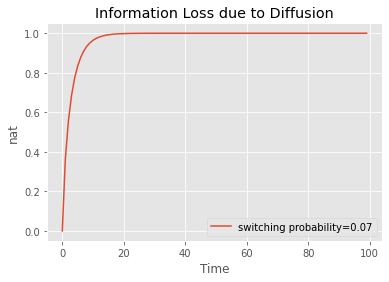

In [13]:
#@title Interactive Cell { run : "auto" }

T = 100
switch_prob = 0.07 #@param {type:"slider", min:0.01, max:0.9, step:0.01}
model = my_create_model(switch_prob=switch_prob,noise_level=0.5)
information_loss, marginal_list = simulate_prediction_only(model, T)

plot_info_loss(information_loss, switch_prob)

Video available at https://youtu.be/EGb40GHTPgM


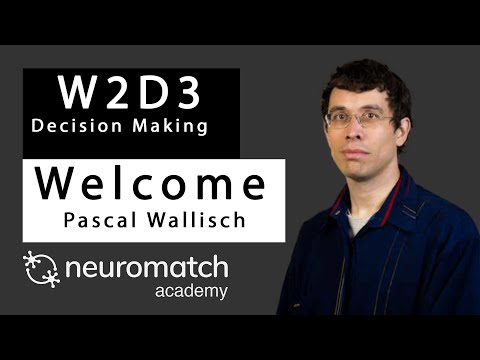

In [14]:
#@title Exercise 2 Video
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="EGb40GHTPgM", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

---

### EXERCISE 2: Gain information from evidence
As shown in Exercise 1, you lose information exponentially when predicting into future without further evidence because HMM will diffuse through a exponential number of possible paths. However HMM generates an observation at each time step and we can use these as evidence to improve our state estimate.


Now let's incorporate evidence into our inference. In this exercise we will calculate the posterior marginal distribution $p(x_t|y_{1:t})$ recursively given evidence $y_t$ using the forward pass of the forward-backward algorithm.
That is saying, suppose we know the posterior marginal of $x_{t-1}$ given all observations up to $t-1$, when a new observation $y_t$ comes in, from Bayes' rule and the Markov property, we can get $p(x_{t}|y_{1:t})\propto p(x_t|y_{1:t-1})p(y_{t}|x_t)$, where the first term is the prediction which can be calculated as shown in last exercise and the second term in the new data likelihood for two components:
$$\text{Posterior}(x_t|y_{1:t}) \propto \text{Prediction}(x_t|y_{1:t-1}) \odot \text{Likelihood}(y_t|x_t)$$

**Suggestions**

- Create a model with switching probability $0.1$ and noise level $0.5$ using function `my_create_model(switch_prob, noise_level)`

- Calculate marginal posterior distribution $p(x_t|y_{1:t-1})$ at time $t$  from last posterior $p(x_{t-1}|y_{1:t-1})$ at time $t-1$ 
    - Calculate the predictive distrubition $p(x_t =i|y_{1:t-1})=\sum_j A_{ji} p(x_{t-1}=j|y_{1:t-1})$
    - Calculate the likelihood of new data under each component using `exp(model._compute_log_likelihood(yt))`
    - Multiply likelihood and prediction element-wise and normalize over two components to get the new posterior probabilities

- Calculate the information gain by subtracting the posterior entropy from information loss from last exercise. This is already coded.

- Plot the average information gain due to evidence together with information loss without evidence using our provided code.


In [15]:
#@title Plotting function
def plot_info_gain(info_gain_matrix, information_losses):
  """Plots the information gain and loss over time.
    
  Args:
    info_gain_matrix: (2d numpy array of floats): The information gain from evidence (samples, time)
    information_lossed (numpy array of floats):   Information loss due to diffusion.
  """
  nsample, T = info_gain_matrix.shape
  info_gain_mean = info_gain_matrix.mean(axis=0)
  fig, ax = plt.subplots(1)
  ax.scatter(np.tile(np.arange(T),(nsample,1)),info_gain_matrix,s=0.4,c="green",alpha=0.3)
  ax.plot(np.arange(T),information_losses,c='orange',linewidth=2)
  ax.plot(np.arange(T), info_gain_mean,c='green',linewidth=2)
  ax.legend(["Info Loss without evidence","Info Gain with evidence"])
  ax.set_xlabel("Time")
  ax.set_ylabel("Bits")
  plt.show(fig)
help(plot_info_gain)

Help on function plot_info_gain in module __main__:

plot_info_gain(info_gain_matrix, information_losses)
    Plots the information gain and loss over time.
      
    Args:
      info_gain_matrix: (2d numpy array of floats): The information gain from evidence (samples, time)
      information_lossed (numpy array of floats):   Information loss due to diffusion.



In [16]:
def simulate_info_gain(model,T):
    """
    Given HMM `model`, generate a sequence of observations from first component, and 
    calculate posterior marginal predictions and corresponding information gain(compared to no evidence) 
    of x_t for T-1 time steps ahead based on generated evidence

    Args:
        model (GaussianHMM instance): the HMM
        T (int): length of returned array

    Returns:
        posterior_probs (list of numpy vectors): the list of marginal probs. from time 0 to T-1
        information_gains (numpy array of floats): entropy decrease w.r.t no evidence
        information_losses (numpy array of floats): entropy increase w.r.t first time step
    """
    
    # First re-calculate the information loss for current model 
    information_losses, predictive_probs = simulate_prediction_only(model, T)
    # Generate an observation trajectory condtioned on that latent state x is always 1
    Y = np.asarray([model._generate_sample_from_state(0) for _ in range(T)])
    # Calculate marginal for each latent state x_t 
    pt = np.exp(model._compute_log_likelihood(Y[0:1]))[0] * model.startprob_
    pt /= np.sum(pt)
    posterior_probs = [pt]
    ###############################################################################
    ## Insert your code here to:
    ##      Calculate posterior distributions of x_t for all time steps and collect all posteriors
    ##          hint: don't forget to normalize the posterior to compensate for numerical error
    ##      For each posterior, calculate the entropy
    ##      Calculate the information gain as the difference between original information loss without evidence
    ##          and the entropy now with evidence
    ###############################################################################
    for t in range(1,T):
        # prediction = ...
        # likelihood = ...
        # posterior = ...
        # normalize and add to the list
        posterior /= np.sum(posterior)
        posterior_probs.append(posterior)
        if 'posterior' not in locals():
            raise NotImplementedError("function `simulate_info_gain` incomplete")
        
    # Calculate entropy for each posterior marginal 
    posterior_entropies = np.asarray(list(map(entropy_categorical,posterior_probs)))
    # Calculate infomation gain 
    information_gains = information_losses - posterior_entropies
    return posterior_probs, information_gains, information_losses
    



###############################################################################
## After finishing the above exercises, please un-comment the following lines
###############################################################################
# switch_prob = 0.06 
# noise_level = 1.2
# nsample = 50 
# T = 160  
# model = my_create_model(switch_prob, noise_level)

# info_gain_list = [] 
# for i in range(nsample):
#     posterior_probs, information_gains, information_losses = simulate_info_gain(model,T)
#     info_gain_list.append(information_gains)
# info_gain_matrix = np.asarray(info_gain_list)


# plot_info_gain(info_gain_matrix, information_losses)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D3_DecisionMaking/solutions/W2D3_Tutorial2_Solution_907509a5.py)

*Example output:*

<img alt='Solution hint' align='left' width=410 height=281 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D3_DecisionMaking/static/W2D3_Tutorial2_Solution_907509a5_0.png>



Now you've got a plot of information loss due to diffusion together with the information recovered/uncertainty reduced due to evidence. The difference between the former and the latter is the amount of uncertainty that still remains because of observation noise. You could get a sense of this by changing the noise level in the following cell.

**Suggestions**

- In the following interactive cell, adjust the switch probability and noise level and observe how information gain changes with signal-to-noise ratio and/or switch probability. *Hint*: you can click `...`>`Form`>`Hide code` to hide the code section if the slider is too far from the figure.

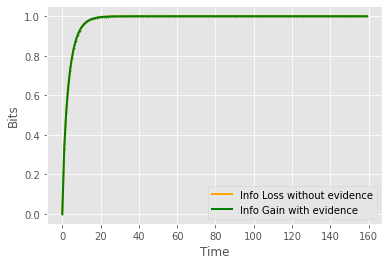

In [18]:
#@title Interactive Cell { run : "auto" }
switch_prob = 0.06 #@param {type:"slider", min:0.01, max:0.9, step:0.01}
noise_level = 0.2 #@param {type:"slider", min:0.1, max:3.0, step:0.05}
nsample = 50 #@param {type:"slider", min:5, max:200, step:5}
T = 160  #@param {type:"slider", min:20, max:300, step:5}
model = my_create_model(switch_prob, noise_level)

info_gain_list = [] 
for i in range(nsample):
    posterior_probs, information_gains, information_losses = simulate_info_gain(model,T)
    info_gain_list.append(information_gains)
info_gain_matrix = np.asarray(info_gain_list)


plot_info_gain(info_gain_matrix, information_losses)

Video available at https://youtu.be/VaZkkD4JF7I


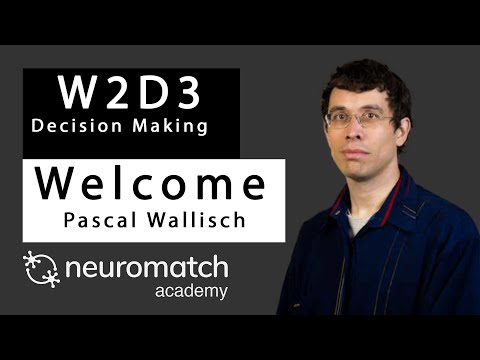

In [19]:
#@title Case Study 1 Video Placeholder
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="VaZkkD4JF7I", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

## HMM for Poisson spiking neuronal network
Thalamic relay neurons fire in two distinct modes: a tonic mode where spikes are produced one at a time, and a 'burst mode' where several action potentials are produced in rapid succession. These modes are thought to differentially encode how the neurons relay information from sensory receptors to cortex. A distinct molecular mechanism, T-type calcium channels, switches neurons between modes, but it is very challenging to measure in the brain of a living monkey. However, statistical approaches let us recover the hidden state of those calcium channels purely from their spiking activity, which can be measured in a behaving monkey.

Here, we're going to tackle a simplified version of that problem.


---

Let's consider the formulation mentioned in the intro lecture. 
We have a network of $C$ neurons switching between $K$ states. Neuron $c$ has firing rate $\lambda_i^c$ in state $i$. The transition between states are represented by the $K\times K$ transition matrix $A_i$ and initial probability $\psi$ at time $t=1$.

Let $y_t^c$ be the number of spikes for cell $c$ in time bin $t$.

In the following exerices, you will

* Define an instance of such model with $C=5$ and $K=3$
* Generate a dataset from this model
* Implement the E-step and M-step for this HMM
* Run EM to estimate all parameters $A,\psi,\lambda_i^c$
* Plot the learning likelihood curve
* Plot expected complete log likelihood versus data log likelihood
* Compare learnt parameters versus true parameters 

---


### Review: EM algorithm for HMM 
Consider a HMM with $K$ latent states. In the E-step, we want the single and pairwise marginal distributions of $p_{\theta}(X_{1:T}|Y_{1:T})$ : $\gamma_i(t) :=p_{\theta}(x_t=i|Y_{1:T})$ and $\xi_{ij}(t)=p_{\theta}(x_{t}=i,x_{t+1}=j|Y_{1:T})$

This can be achieved by applying the forward-backward algorithm.

#### E-step: Forward-backward algorithm 
In the forward pass, we calculate the marginal distribution of $x_t$ given $Y_{1:t}$: $a_i(t):=p(x_t=i|Y_{1:t})$ recursively

$$a_i(t) = p_(y_t|x_i=t)\sum_j A_{ji} a_j(t-1)$$

In contrast to the intro, now $A_{ji}$ means the transition probability from state $j$ to state $i$.

The backward pass calculate the probabilities $b_i(t):=p_{\theta}(x_t=i|Y_{t+1:T})$, which is the inference of $x_t$ given all future information. The recursion of $b_i(t)$ is given by 

$$ b_i(t) = \sum_j p_{\theta}(y_{t+1}|x_{t+1}=j)b_j(t+1)A_{ij} $$

Combining all past and future information, the single and pairwise marginal distributions are given by 

$$ \gamma_{i}(t):=p_{\theta}\left(x_{t}=i | Y_{1: T}\right)=\frac{a_{i}(t) b_{i}(t)}{p_{\theta}\left(Y_{1: T}\right)} $$ 

$$  \xi_{i j}(t)=\frac{b_{j}(t+1) p_{\theta}\left(y_{t+1} | x_{t+1}=j\right) A_{i j} a_{i}(t)}{p_{\theta}\left(Y_{1: T}\right)} $$

where $p_{\theta}(Y_{1:T})=\sum_i a_i(T)$.

#### M-step

The M-step for HMM has a closed-form solution. First the new transition matrix is given by 
$$ 
 A_{ij} =\frac{\sum_{t=1}^{T-1} \xi_{i j}(t)}{\sum_{t=1}^{T-1} \gamma_{i}(t)}
$$

which is the expected empirical transition probabilities. 
New initial probabilities and parameters of the emission models are also given by their empirical values given single and pairwise marginal distributions:

$$ \psi_i = \sum_{t=1}^{T-1}\gamma_i(t) $$ 

$$ \lambda_{i}^{c}=\frac{\sum_{t} \gamma_{i}(t) y_{t}^{c}}{\sum_{t} \gamma_{i}(t) d t}$$




Video available at https://youtu.be/oh_2W95HTnA


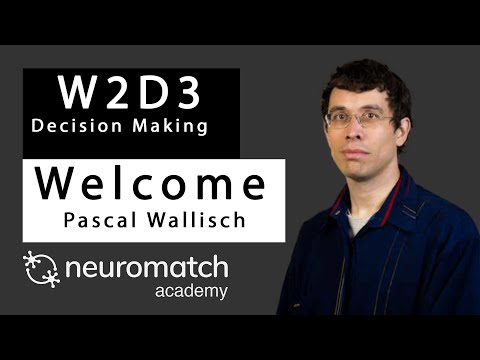

In [20]:
#@title Exercise 3 Video
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="oh_2W95HTnA", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

---


### EXERCISE 3: Define model and generate data

Let's first generate a random state sequence from the hidden Markov Chain, and generate `n_frozen_trials` trials of spike trains for each cell assuming the underlying sequence is frozen as the one we just generated for all trials.

**Suggestions**

1. Run the following two sections **Model and simulation parameters** and **Initialize true model** to define a true model and parameters that will be used in our following exercises. Please take a look at the parameters and come back to these two cells if you encounter a variable you don't know in the future.

2. 



In [21]:
#@title Plotting functions
def plot_spike_train(X, Y, dt):
    """Plots the spike train for cells across trials and overlay the state.
        
      Args:
        X: (2d numpy array of binary values): The state sequence in a one-hot representation.
                                              (T, states)
        Y: (3d numpy array of floats):        The spike sequence.
                                              (trials, T, C)
        dt (float):                           Interval for a bin.
    """
    n_trials, T, C = Y.shape
    trial_T = T * dt
    fig = plt.figure(figsize=(1.5 * (12.8 + 6.4), 1.5 * 9.6))

    # plot state sequence
    starts = [0] + list(np.diff(X.nonzero()[1]).nonzero()[0])
    stops = list(np.diff(X.nonzero()[1]).nonzero()[0]) + [T]
    states = [X[i + 1].nonzero()[0][0] for i in starts]
    for a, b, i in zip(starts, stops, states):
        rect = patches.Rectangle((a * dt, 0), (b - a) * dt, n_trials * C,
                                 facecolor=plt.get_cmap('tab10').colors[i], alpha=0.15)
        plt.gca().add_patch(rect)

    # plot rasters
    for c in range(C):
        if c > 0:
            plt.plot([0, trial_T], [c * n_trials, c * n_trials],
                     color=plt.get_cmap('tab10').colors[0])
        for r in range(n_trials): 
            tmp = Y[r, :, c].nonzero()[0]
            if len(tmp) > 0: plt.plot(np.stack((tmp, tmp)) * dt,
                                      (c * n_trials + r + 0.1, c * n_trials + r + .9),
                                      'w', linewidth=1.)
                
    ax = plt.gca()
    plt.yticks(np.arange(0, n_trials * C, n_trials),
               labels=np.arange(C, dtype=int))
    fig.set_facecolor('#434343')
    ax.set_facecolor('#434343')
    ax.tick_params(color='w', labelcolor='w')
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w') 
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.yaxis.label.set_color('white')
    ax.xaxis.label.set_color('white')
    plt.xlabel('time (s)', fontsize=16, color='w')
    plt.ylabel('Cell number', fontsize=16, color='w')
help(plot_spike_train)

Help on function plot_spike_train in module __main__:

plot_spike_train(X, Y, dt)
    Plots the spike train for cells across trials and overlay the state.
      
    Args:
      X: (2d numpy array of binary values): The state sequence in a one-hot representation.
                                            (T, states)
      Y: (3d numpy array of floats):        The spike sequence.
                                            (trials, T, C)
      dt (float):                           Interval for a bin.



#### Model and simulation parameters

In [22]:
# model and data parameters
C = 5  # number of cells
K = 3  # number of states
dt = 0.002  # seconds
trial_T = 2.0  # seconds
n_frozen_trials = 20  # used to plot multiple trials with the same state sequence
n_trials = 300  # number of trials (each has it's own state sequence)

# for random data
max_firing_rate = 50  # Hz
max_transition_rate = 3  # Hz

# needed to plot LL and ECLL for every M-step
# **This substantially slows things down!!**
num_plot_vals = 10  # resolution of the plot (this is the expensive part)
b_lims = (-1, 2)  # lower limit on graph (b = 0 is start-of-M-step LL; b = 1 is end-of-M-step LL)
plot_epochs = list(range(9))  # list of epochs to plot

#### Initialize true model

In [23]:
np.random.seed(9)
T = round(trial_T / dt)
ts = np.arange(T)

# initial state distribution
psi = np.arange(1, K + 1)
psi = psi / psi.sum()

# off-diagonal transition rates sampled uniformly
A = np.random.rand(K, K) * max_transition_rate * dt
A = (1 - np.eye(K)) * A
A = A + np.diag(1 - A.sum(1))

# hand-crafted firing rates make good plots
L = np.array([
    [.02, .8, .37],
    [1., .7, .1],
    [.92, .07, .5],
    [.25, .42, .75],
    [.15, .2, .85]
]) * max_firing_rate     # (C,K)

# Save true parameters for comparison later
psi_true = psi
A_true = A
L_true = L

#### Generate data with frozen sequence and plot
Given a state sequence `[0,1,1,3,2,...]`, we'll first convert each state in to sequence in to the so-called "one-hot" coding. For example, with 5 total states, the one-hot coding of state `0` is `[1,0,0,0,0]` and the coding for state `3` is `[0,0,0,1,0]`. Suppose we now have a sequence of length `T`, the one-hot coding of this sequence `Xf` will have shape `(T,K)`

In [24]:
# sample n_frozen_trials state sequences
Xf = np.zeros(T, dtype=int)
Xf[0] = (psi.cumsum() > np.random.rand()).argmax()
for t in range(1, T):
    Xf[t] = (A[Xf[t - 1],:].cumsum() > np.random.rand()).argmax()

# switch to one-hot encoding of the state
Xf = np.eye(K, dtype=int)[Xf]  # (T,K)

# get the Y values
###############################################################################
## Insert your code here to:
##      Calculate the sequences of Poisson rates of each given the state sequence
##      and assign to `Rates` with size (T,C). You only need to reshape the array
##      Hint: L has shape (C,K), Xf has shape (T,K), then we can reshape Xf as (T,K,1)
##          and calculate: Rate (T,C,1) = L (C,K) @ Xf (T,K,1). Please reshape the output
##          to shape (T,C)
###############################################################################
# Rates =  ...(L @ Xf[...,None]) * dt


###############################################################################
## Please un-comment to following codes after finishing this cell
###############################################################################
# Rates = np.tile(Rates, [n_trials,1,1]) # (n_trials, T, C)
# Yf = ss.poisson(Rates).rvs()  

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D3_DecisionMaking/solutions/W2D3_Tutorial2_Solution_83cea173.py)



Now let's plot our generated spike trains

In [26]:
## Please un-comment the following line to plot the spike train we just generated
## Background color indicates state

# plot_spike_train(Xf, Yf, dt)

#### Generate data for EM learning

The previous dataset is generated with the same state sequence for visualization. Now let's generate `n_trials` trials of observations, each one with its own randomly generated sequence

Video available at https://youtu.be/t-Bqk0zIJVM


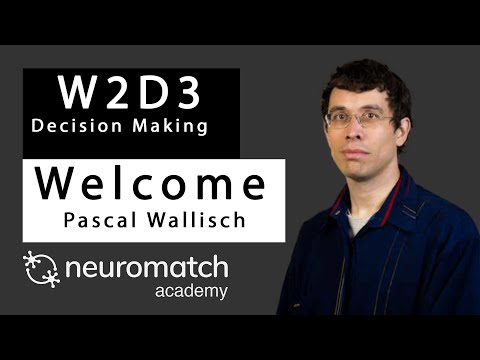

In [27]:
#@title Exercise 4 Video
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="t-Bqk0zIJVM", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

In [28]:
# sample n_trials state sequences
X = np.zeros((n_trials, T), dtype=int)
X[:, 0] = (psi_true.cumsum(0)[:, None] > np.random.rand(n_trials)).argmax(0)
for t in range(1, T):
    X[:, t] = (A_true[X[:, t - 1], :].T.cumsum(0) > np.random.rand(n_trials)).argmax(0)

# switch to one-hot encoding of the state
one_hot = np.eye(K)[np.array(X).reshape(-1)]
X = one_hot.reshape(list(X.shape) + [K])

# get the Y values
Y = ss.poisson(np.squeeze(L_true @ X[..., None]) * dt).rvs()  # (n_trials, T, C)
print("Y has shape: (n_trial={},T={},C={})".format(*Y.shape))

Y has shape: (n_trial=300,T=1000,C=5)


Video available at https://youtu.be/td4t3SGiy-E


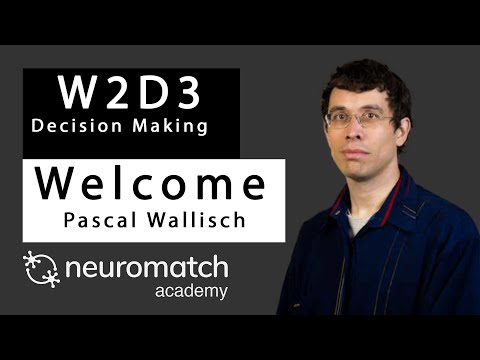

In [29]:
#@title Exercise 4
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="td4t3SGiy-E", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

---


### EXERCISE 4: E-step: forward and backward algorithm

In this exercise you will need to complete the code for the forward-backward algorithm. 


Here's how to implement it in `numpy`:

What we want is to calculate the following formula

$$b^t_i = \sum_j A_{ij} o_j^{t+1}b_j^{t+1} $$ where $o_j^{t+1}=p(y_{t+1}|x_{t+1}=j)$ .

Let's forget the meanings of these symbols for now. What we have in hand are:
* `A`: matrix of size `(K,K)`
* `o^{t+1}`: array of size `(N,K)` is the log data likelihood for all trials at a given time
* `b^{t+1}`: array of size `(N,K)` is the backward probability for all trials at a given time

where `N` stands for the number of trials.

The shape (second to last) doesn't match for these three arrays, so we can't just multiply them together. However, we can do this by viewing $o^{t+1}_j$ and $b^{t+1}_j$ also as a matrix and re-write the back equation as:

$$b^t_i = \sum_j A_{ij} o_{1j}^{t+1}b_{1j}^{t+1} $$

Now we can just multiply these three arrays element-wise and sum over the last dimension.

In `numpy`, we can achieve this by indexing the array with `None` at the location we want to insert a dimension. Take `b` with size `(N,T,K)` for example, `b[:,t,None,:]` will have shape `(N,1,K)` and `b[:,t,:,None]` will have shape `(N,K,1)`.

So the backward recursion computation can be implemented as 

```python
b[:,t,:] = (A * o[:,t+1,None,:] * b[:,t+1,None,:]).sum(-1)
```

---

In this exercise, we will work in the log scale for numerical stability.


**Suggestions** 

1. Take a look at the code for the forward recursion, complete the backward recursion.

    




In [30]:
def e_step(Y, psi, A, L, dt):
    """
    Args:
        Y (numpy 3d array): tensor of recordings, has shape (n_trials, T, C)
        psi (numpy vector): initial probabilities for each state
        A (numpy matrix): transition matrix, A[i,j] represents the prob to switch from i to j. Has shape (K,K)
        L (numpy matrix): Poisson rate parameter for different cells. Has shape (C,K)
        dt (float): duration of a time bin
        
    Returns:
        ll (float): data log likelihood
        gamma (numpy 3d array): singleton marginal distribution. Has shape (n_trials, T, K)
        xi (numpy 4d array): pairwise marginal distribution for adjacent nodes . Has shape (n_trials, T-1, K, K)
    """
    n_trials = Y.shape[0]
    T = Y.shape[1]
    K = p.size
    log_a = np.zeros((n_trials, T, K))
    log_b = np.zeros((n_trials, T, K))

    log_A = np.log(A)
    # summing over all cells to get log of joint observation probs. for all cells
    log_obs = stats.poisson(L * dt).logpmf(Y[..., None]).sum(-2)  # (n_trials, T, K)

    # forward pass
    log_a[:, 0] = log_obs[:, 0] + np.log(psi)
    for t in range(1, T):
        tmp = log_A + log_a[:, t - 1, :,None]  # (n_trials, K,K)
        maxtmp = tmp.max(-2)  # (n_trials,K)
        log_a[:, t] = log_obs[:, t] + maxtmp + np.log(np.exp(tmp - maxtmp[:, None]).sum(-2))

    # backward pass
    for t in range(T - 2, -1, -1):
        ###############################################################################
        ## Insert your code here to:
        ##      Complete the backward pass 
        ##      Hint: you could refer to the forward pass but notice the order of indices. Which dimension
        ##          should we sum over? 
        ###############################################################################

        tmp = log_A + log_b[:, t + 1, None] + log_obs[:, t + 1, :, None]
        # maxtmp = ...
        # lb[:,t] = maxtmp + np.log( (...).sum(-1))

    # data log likelihood 
    maxtmp = log_a[:, -1].max(-1)
    ll = np.log(np.exp(log_a[:, -1] - maxtmp[:, None]).sum(-1)) + maxtmp
    
    # singleton and pairwise marginal distributions 
    gamma = np.exp(log_a + log_b - ll[:, None, None])
    xi = np.exp(log_a[:, :-1, :, None] + (log_obs + log_b)[:, 1:, None] + log_A - ll[:, None, None, None])

    return ll.mean() / T / dt, gamma, xi

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D3_DecisionMaking/solutions/W2D3_Tutorial2_Solution_3b612773.py)



---

### EXERCISE 5: M-step

In this exercise you will complete the M-step for this HMM using closed form solutions reviewed before.

**Suggestions**

1. Calculate new initial probabilities as empirical counts of singleton marginals

$$  \psi_i = \sum_{t=1}^{T-1}\gamma_i(t)$$ 


2. Calculate new transition matrix as the empirical counts from marginals

$$ A_{ij} =\frac{\sum_{t=1}^{T-1} \xi_{i j}(t)}{\sum_{t=1}^{T-1} \gamma_{i}(t)}$$ 


3. Calculate new spiking rates for each cell and each state

$$  \lambda_{i}^{c}=\frac{\sum_{t} \gamma_{i}(t) y_{t}^{c}}{\sum_{t} \gamma_{i}(t) d t} $$

4. Remember the extra trial dimension and average over all trials

####Initialization for parameters


In [32]:
# number of EM steps
epochs = 5
print_every = 1

# initial state distribution
psi = np.arange(1, K + 1)
psi = psi / psi.sum()

# off-diagonal transition rates sampled uniformly
A = np.ones((K, K)) * max_transition_rate * dt / 2
A = (1 - np.eye(K)) * A
A = A + np.diag(1 - A.sum(1))

# firing rates sampled uniformly
L = np.random.rand(C, K) * max_firing_rate

In [33]:
# LL for true vs. initial parameters
print(f'LL for true 𝜃:    {e_step(Y, psi_true, A_true, L_true, dt)[0]}')
print(f'LL for initial 𝜃: {e_step(Y, psi, A, L, dt)[0]}')

LL for true 𝜃:    -459.03260685874227


LL for initial 𝜃: -485.61002074708534


In [34]:
save_vals = []
lls = []
for e in range(epochs):

    ###############################################################################
    ## Delete the `break` statement after finishing this section 
    ###############################################################################
    break

    # Run E-step
    ll, gamma, xi = e_step(Y, psi, A, L, dt)    
    lls.append(ll)  # log the data log likelihood for current cycle
    
    if e % print_every == 0: print(f'epoch: {e:3d}, ll = {ll}')  # log progress
    ###############################################################################
    ## Insert your code here to:
    ##      * Calculate new initial probabilities
    ##      * Calculate new transition matrix 
    ##      * Calculate new firing rates
    ##      Don't forget to averagin over trial dimension
    ###############################################################################
    ## Calculate new initial probabilities
    # psi_new = ...
    ## Normalize psi_new
    ## Calculate new transition matrix
    # A_new = ...
    ## Calculate new firing rates
    # L_new = ...

    dp, dA, dL = psi_new - psi, A_new - A, L_new - L # Calculate the difference of parameters for later interpolation/extrapolation
    # Calculate LLs and ECLLs for later plotting
    if e in plot_epochs:        
        b_min = -min([np.min(psi[dp > 0] / dp[dp > 0]), np.min(A[dA > 0] / dA[dA > 0]), np.min(L[dL > 0] / dL[dL > 0])])
        b_max = -max([np.max(psi[dp < 0] / dp[dp < 0]), np.max(A[dA < 0] / dA[dA < 0]), np.max(L[dL < 0] / dL[dL < 0])])
        b_min = np.max([.99 * b_min, b_lims[0]])
        b_max = np.min([.99 * b_max, b_lims[1]])    
        bs = np.linspace(b_min, b_max, num_plot_vals)
        bs = sorted(list(set(np.hstack((bs, [0, 1])))))
        bs = np.array(bs)
        lls_for_plot = []
        eclls_for_plot = []
        for i, b in enumerate(bs):
            print(f'  saving for plot: {b_min:5.2f} ≤ {b:5.2f} ≤ {b_max:5.2f} ({i + 1} of {len(bs)})\r', end='')
            ll = e_step(Y, psi + b * dp, A + b * dA, L + b * dL, dt)[0]
            lls_for_plot.append(ll)
            ecll = (gamma[:, 0] @ np.log(psi + b * dp) + (xi * np.log(A + b * dA)).sum(-1).sum(-1).sum(-1) + (gamma * ss.poisson((L + b * dL) * dt).logpmf(Y[..., None]).sum(-2)).sum(-1).sum(-1)).mean() / T / dt
            eclls_for_plot.append(ecll)
            if b == 0:
                diff_ll = ll - ecll
        lls_for_plot = np.array(lls_for_plot)
        eclls_for_plot = np.array(eclls_for_plot) + diff_ll
        save_vals.append((bs, lls_for_plot, eclls_for_plot))
        print('')
    # return new parameter 
    psi, A, L = psi_new, A_new, L_new
    
ll = e_step(Y, psi, A, L, dt)[0]
lls.append(ll)
print(f'epoch: {epochs:3d}, ll = {ll}')

epoch:   5, ll = -485.61002074708534


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D3_DecisionMaking/solutions/W2D3_Tutorial2_Solution_ffbee94f.py)



In [36]:
# EM doesn't guarantee the order of learnt latent states are the same as that of true model
#  so we need to sort learnt parameters

sort = []
###############################################################################
## Insert your code here to:
##      Sort learnt states to match true states by comparing L and L_true
###############################################################################
for i in range(K):
    pass 

# psi = psi[sort]
# A = A[sort]
# A = A[:, sort]
# L = L[:, sort]

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D3_DecisionMaking/solutions/W2D3_Tutorial2_Solution_422cd01f.py)



Video available at https://youtu.be/2d6iMcsnrdg


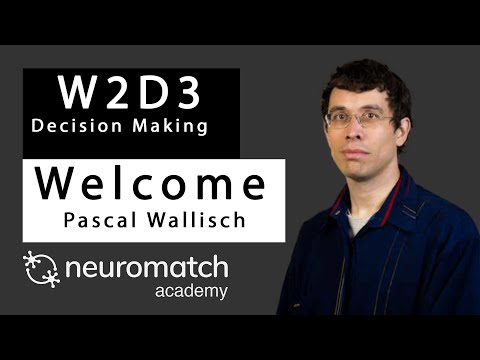

In [38]:
#@title Exercise 6 Video Placeholder
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="2d6iMcsnrdg", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

---

### EXERCISE 6: Plotting!

In this exercise you will 

* Plot the likelihood during training
* Plot the M-step log likelihood versus expected complete log likelihood(ECLL) to get an intuition of how EM works and the convexity of ECLL
* Plot learnt parameters versus true parameters 

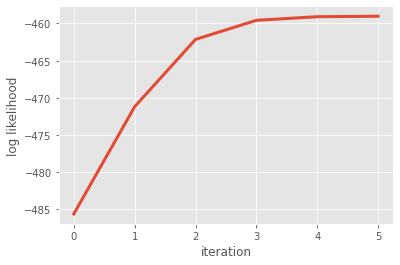

In [39]:
fig, ax = plt.subplots()
ax.plot(range(epochs + 1) , lls, linewidth=3)
span = max(lls) - min(lls)
ax.set_ylim(min(lls) - span * 0.05, max(lls) + span * 0.05)
plt.xlabel('iteration')
plt.ylabel('log likelihood');

/opt/hostedtoolcache/Python/3.7.7/x64/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/opt/hostedtoolcache/Python/3.7.7/x64/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/opt/hostedtoolcache/Python/3.7.7/x64/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged neste

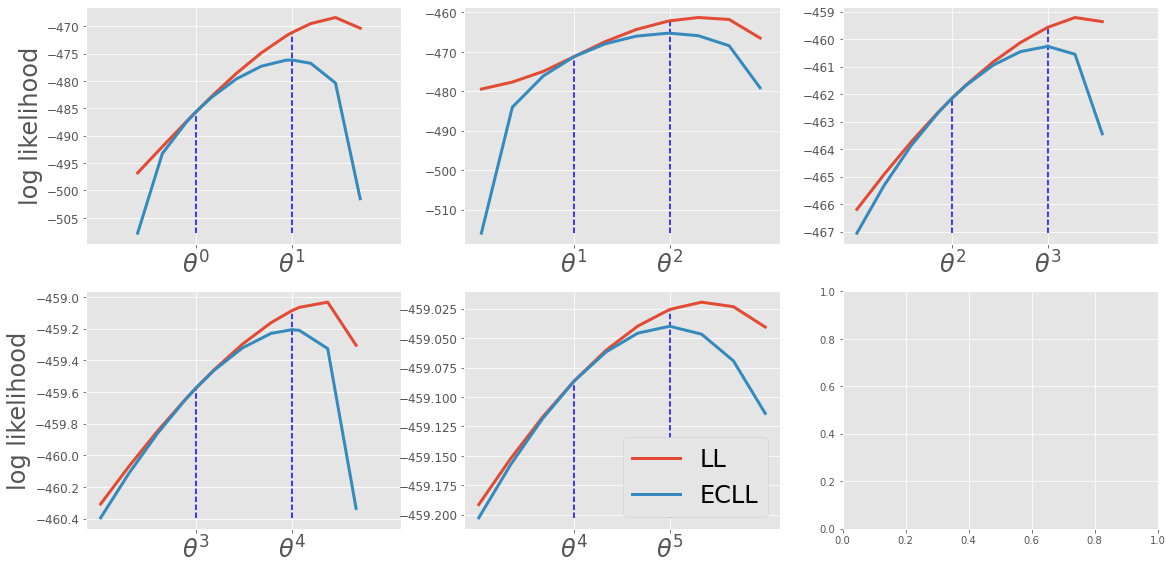

In [40]:
rows = int(np.ceil(min(len(plot_epochs), len(save_vals)) / 3))
fig, axes = plt.subplots(rows, 3, figsize=(6.4 * 3, 4.8 * rows))
axes = axes.flatten()

minll, maxll = np.inf, -np.inf
for i, (ax, (bs, lls_for_plot, eclls_for_plot)) in enumerate(zip(axes, save_vals)):
    ax.set_xlim([-1.15, 2.15])
    min_val = np.stack((lls_for_plot, eclls_for_plot)).min()
    max_val = np.stack((lls_for_plot, eclls_for_plot)).max()
    
    ax.plot([0, 0], [min_val, lls_for_plot[bs == 0]], '--b')
    ax.plot([1, 1], [min_val, lls_for_plot[bs == 1]], '--b')
    ax.set_xticks([0, 1])
    ax.set_xticklabels([f'$\\theta^{plot_epochs[i]}$', f'$\\theta^{plot_epochs[i] + 1}$'])
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=24)

    
    ax.plot(bs, lls_for_plot, linewidth=3)
    ax.plot(bs, eclls_for_plot, linewidth=3)

    if min_val < minll: minll = min_val
    if max_val > maxll: maxll = max_val

    if i % 3 == 0: ax.set_ylabel('log likelihood', fontsize=24)
    if i == 4:
        l = ax.legend(ax.lines[-2:], ['LL', 'ECLL'], fontsize=24, framealpha=1)

---

### EXERCISE 7: Plot learnt parameters vs. true parameters

In this exercise we will plot the (sorted) learnt parameters with true parameters to see if we successfully recovered all the parameters


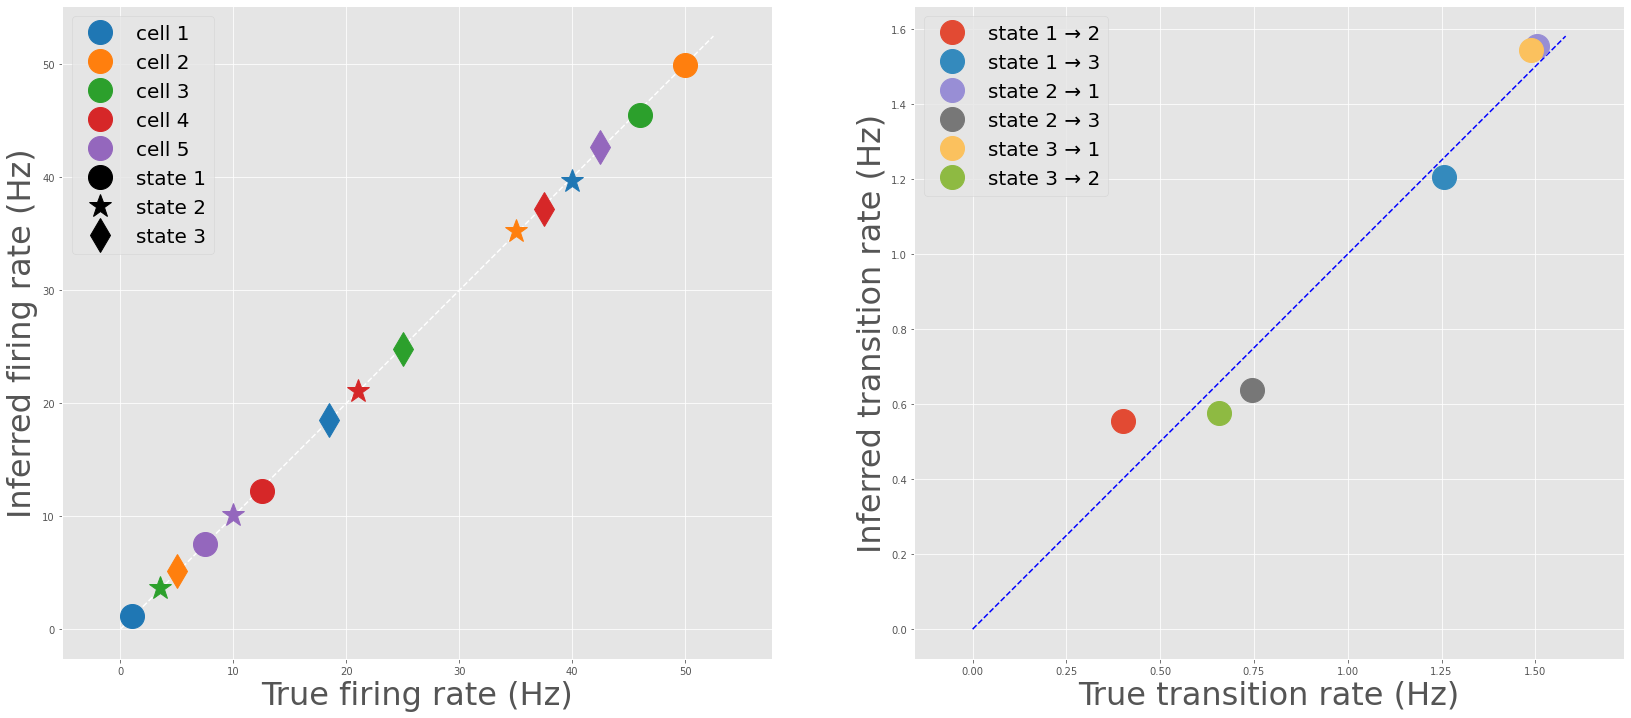

In [41]:
fig = plt.figure(figsize=(28, 12))
plt.subplot(121)
plt.plot([0, L_true.max() * 1.05], [0, L_true.max() * 1.05], '--w')
for i in range(K):
    for c in range(C):
        plt.plot(L_true[c, i], L[c, i], color=plt.get_cmap('tab10').colors[c], markersize=24, marker=['o', '*', 'd'][i])  # this line will fail for K > 3
ax = plt.gca()
ax.axis('equal')
plt.xlabel('True firing rate (Hz)', fontsize=32)
plt.ylabel('Inferred firing rate (Hz)', fontsize=32)
xlim, ylim = ax.get_xlim(), ax.get_ylim()
for c in range(C):
    plt.plot([-10^6], [-10^6], 'o', color=plt.get_cmap('tab10').colors[c], markersize=24)
for i in range(K):
    plt.plot([-10^6], [-10^6], '.', marker=['o', '*', 'd'][i], markersize=24, c="black")
l = plt.legend(ax.lines[-C - K:], [f'cell {c + 1}' for c in range(C)] + [f'state {i + 1}' for i in range(K)],fontsize=20)
ax.set_xlim(xlim), ax.set_ylim(ylim)

plt.subplot(122)
ymax = np.max(A_true - np.diag(np.diag(A_true))) / dt * 1.05
plt.plot([0, ymax], [0, ymax], '--b')
for j in range(K):
    for i in range(K):
        if i == j: continue
        plt.plot(A_true[i, j] / dt, A[i, j] / dt, 'o', markersize=24)
ax = plt.gca()
ax.axis('equal')
plt.xlabel('True transition rate (Hz)', fontsize=32)
plt.ylabel('Inferred transition rate (Hz)', fontsize=32)
l = plt.legend(ax.lines[1:], ['state 1 → 2', 
                                    'state 1 → 3',
                                    'state 2 → 1', 
                                    'state 2 → 3',
                                    'state 3 → 1',
                                    'state 3 → 2'
                                   ], fontsize=20)